In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')
from PIL import Image

In [3]:
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch
import PIL.ImageOps
import skimage
from sklearn import metrics

In [4]:
SIZE = 224

In [5]:
N_COMPONENT = 600

In [6]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [7]:
transformations = [
                   tfs.Resize((SIZE, SIZE), Image.ADAPTIVE),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))
                    ]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

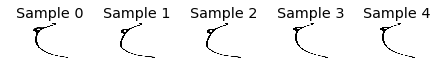

In [8]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [9]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [10]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([
                                                           tfs.Resize((SIZE, SIZE), Image.ADAPTIVE),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           #tfs.Normalize((0.5,), (0.5,))
                                                           ]))



In [11]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [12]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0]-1, splits_len[1], splits_len[2] +2

#### Random split

In [13]:
splits = utils.random_split(imagenet_data, splits_len)

In [14]:
import pickle
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)
print(len(splits[0].indices))

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)
print(len(splits[2].indices))

256
898


In [15]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)

In [16]:
y_real_test, X_test = utils.iterations_test_pixel(test_loader)
y_real_train, X_train = utils.iterations_test_pixel(train_loader)

In [17]:
len(X_test), len(X_train)

(256, 898)

In [18]:
y_real_test, X_test = np.array(y_real_test), np.array(X_test).reshape(-1, SIZE*SIZE)
y_real_train, X_train = np.array(y_real_train), np.array(X_train).reshape(-1, SIZE*SIZE)

In [19]:
import pandas as pd
from time import time
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# PCA

In [20]:
from sklearn import decomposition

In [21]:
pca = decomposition.PCA(n_components=N_COMPONENT)

In [22]:
X_total = np.concatenate((X_train, X_test), axis=0)

In [23]:
pca.fit(X_total)

PCA(copy=True, iterated_power='auto', n_components=600, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
X_train.shape, X_test.shape

((898, 50176), (256, 50176))

In [25]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [26]:
np.sum(pca.explained_variance_ratio_)

0.9852047660882575

In [27]:
files_train = np.array(imagenet_data.imgs)[train_loader.dataset.indices][:, 0]

<Figure size 1296x864 with 0 Axes>

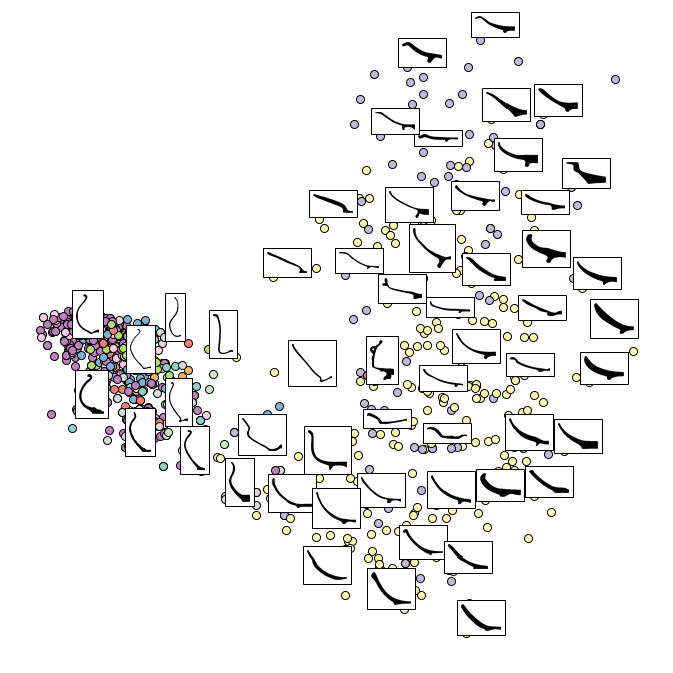

In [28]:
plt.rcParams['figure.figsize'] = [9.0*2, 6.0*2]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))
u = X_train
fig = plt.figure()
#ax = fig.add_subplot(111)
utils.plot_embedding(u[:,[0,1]], merged_train, "", 11)
#ax.scatter(u[:,0], u[:,1], c=c)
plt.gca().set_aspect('equal')
plt.savefig("result_plot/pca_{}/pca{}_224.png".format(N_COMPONENT, N_COMPONENT), dpi=300, bbox_inches='tight')
plt.show()

# UMAP

<Figure size 1296x864 with 0 Axes>

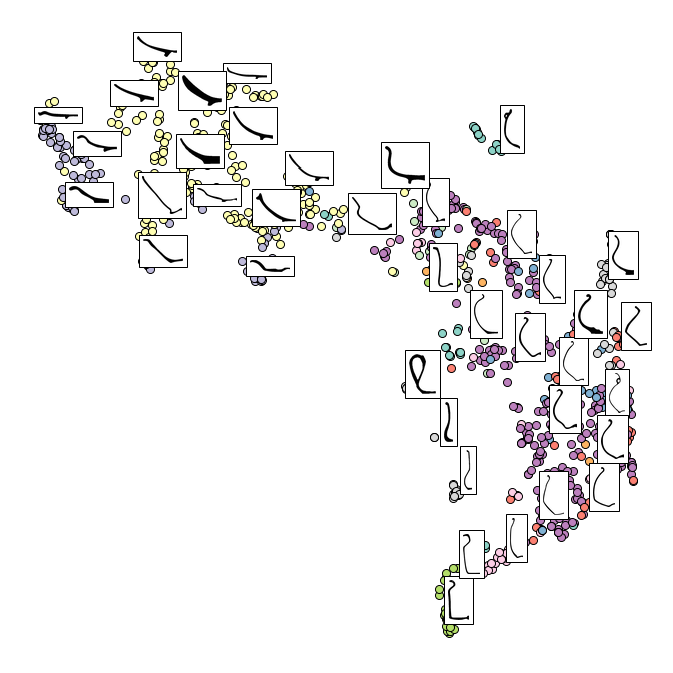

In [29]:
import umap
plt.rcParams['figure.figsize'] = [9.0*2, 6.0*2]
merged_train = pd.DataFrame(np.concatenate(( np.expand_dims(files_train, 1), np.expand_dims(y_real_train, 1)), axis=1))
fit = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean'
    )
u = fit.fit_transform(X_train);
fig = plt.figure()
#ax = fig.add_subplot(111)
utils.plot_embedding(u[:,[0,1]], merged_train, "", 11)
#ax.scatter(u[:,0], u[:,1], c=c)
plt.gca().set_aspect('equal')
plt.savefig("result_plot/pca_{}/unap_pca{}_224.png".format(N_COMPONENT, N_COMPONENT), dpi=300, bbox_inches='tight')
plt.show()

# SVM

In [30]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


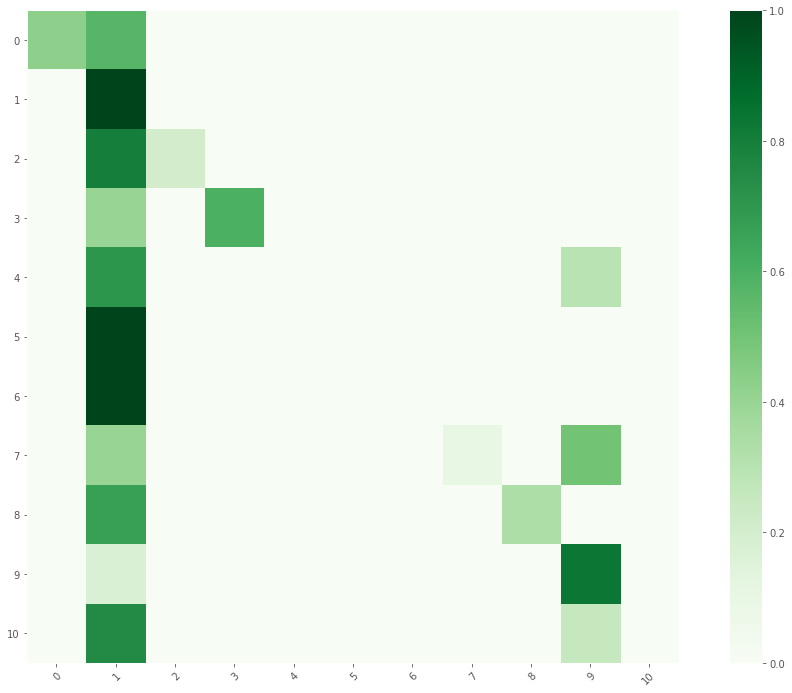

In [31]:
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(10)), "result_plot/pca_{}/svm_confusion_matrix_pca{}_224.png".format(N_COMPONENT, N_COMPONENT), normalize=True)

# RandomForestClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
clf.fit(X_train, y_real_train)
y_pred_test = clf.predict(X_test)

Normalized confusion matrix


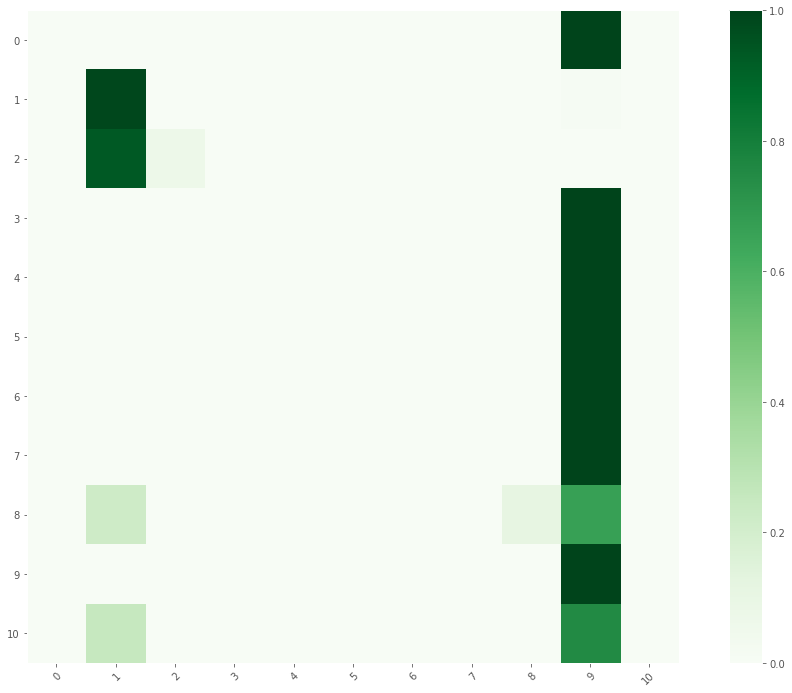

In [33]:
utils.plot_confusion_matrix(y_real_test, y_pred_test, list(range(10)), "result_plot/pca_{}/rfc_confusion_matrix_pca{}_224.png".format(N_COMPONENT, N_COMPONENT), normalize=True)

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import make_scorer

In [35]:
X_train, y_real_train = np.array(X_train), np.array(y_real_train)
X_test, y_real_test = np.array(X_test), np.array(y_real_test)

In [36]:
X_train = np.concatenate((X_train, X_test))

In [37]:
y_real_train = np.concatenate((y_real_train, y_real_test))

# CROSS VAL SVC

In [38]:
precision = lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(precision), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train Precision: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Precision: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Precision: 1.00 (+/- 0.00)
Test Precision: 0.59 (+/- 0.08)


In [39]:
f1score = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(f1score), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train F1Score: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test F1Score: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train F1Score: 1.00 (+/- 0.00)
Test F1Score: 0.35 (+/- 0.06)


In [40]:
recall = lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
clf = SVC(gamma='auto')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(recall), cv=cv,return_estimator=True) 
#scores = cross_val_score(clf, X_test, y_real_test, cv=cv) 
print("Train Recall: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Recall: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Recall: 1.00 (+/- 0.00)
Test Recall: 0.33 (+/- 0.05)


# CROSS VAL RandomForestClassifier

In [41]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(precision), cv=cv,return_estimator=True) 
print("Train Precision: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Precision: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Precision: 0.43 (+/- 0.09)
Test Precision: 0.23 (+/- 0.09)


In [42]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(f1score), cv=cv,return_estimator=True) 
print("Train F1Score: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test F1Score: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train F1Score: 0.27 (+/- 0.04)
Test F1Score: 0.15 (+/- 0.04)


In [43]:
clf = RandomForestClassifier(n_estimators=500,max_depth=4)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=17)
scores = cross_validate(clf, X_train, y_real_train, scoring=make_scorer(recall), cv=cv,return_estimator=True) 
print("Train Recall: %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Test Recall: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Train Recall: 0.27 (+/- 0.04)
Test Recall: 0.19 (+/- 0.01)
